# FINANCIAL COMPLAINT TOPIC MODELING - NMF

### Albert Opoku - Senior Statistical Consultant at Allianca data Inc

#### Contact me:
- twitter [@opalbert](https://twitter.com/opalbert)
- linkedIn [Albert Opoku](https://www.linkedin.com/in/albertopokupmachinelearning/)
- email opalkabert@gmail.com
- website [www.opokualbert.com](https://opokualbert.com/)

### CASE:

Consumers provide feedback on financial products or services and our task is to extract the hidden themes/topics and assign each of the feedback documents to one of these themes or topics.

### Solution:

Train a Natural Language Processing machine learning model to extract the topics from each of the open-ended complaint text document.

### Data Source:

The data is downloaded from kaggle via this url: [consumer complaint data](https://www.kaggle.com/cfpb/us-consumer-finance-complaints)








**Topic Modeling** is an unsupervized machine learning technique to discover the hidden/latent thematic structure in a large corpus of text documents.


[Latent Dirichlet (LDA)](http://jmlr.org/papers/volume3/blei03a/blei03a.pdf) and [Non-Negative Matrix Fatactorization (NMF)](https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf) are the two most popular topic modeling techniques. LDA uses a probabilistic approach where as NMF uses matrix factorization approach.


<img src="NMF_Equation.PNG">

<img src="DTM_.png">

<img src="Doc_Topic_Terms.png">

##### Import the needed packages

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import NMF
import numpy as np
import warnings  
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
%matplotlib inline

import nltk 
# from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
# from nltk.stem import PorterStemmer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df_orig = pd.read_csv("consumer_complaints.csv")

C:\Users\alber\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_orig.shape

(555957, 18)

In [4]:
df_orig.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [5]:
# Check how many rows have missing values for consumer_complaint_narrative column
df_orig.consumer_complaint_narrative.isnull().values.sum()

489151

In [6]:
# extract only the relevant column for this project
df_orig = df_orig.loc[:,['consumer_complaint_narrative']]
# df_orig.to_csv('consumer_complaint_text.csv', index=False)

In [7]:
# Exclude all rows with null consumer_complaint_narrative
df_orig.dropna(inplace=True)
df_orig.shape

(66806, 2)

In [9]:
pd.set_option('max_colwidth', 1000)
pd.options.display.max_rows = 500

In [10]:
# Create a doc id for merging the results back to the original file 
df_orig.insert(0, 'Doc_Id', range(0, 0 + len(df_orig)))
df_orig.head()

,Doc_Id,consumer_complaint_narrative,product
190126,0,XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! \nThey continue to insist I owe them and collection agencies are after me. \nHow can I stop this harassment for a bill I already paid four years ago? \n,Debt collection
190135,1,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in XXXX 2015, per my credit monitoring agency, it showed a delinquent balance of {$0.00}, but when I checked my credit report again on XXXX X...",Consumer Loan
190155,2,"In XX/XX/XXXX my wages that I earned at my job decreased by almost half, by XX/XX/XXXX I knew I was in trouble with my home loan. I began contacting WFB whom my home loan is with, for assitance and options. \nIn early XX/XX/XXXX I began the Loan Modification process with Wells Fargo Bank. I was told that they would not assist me with anything financial on my home loan until I fell 90 days behind, though at the time I started to inquire for assistance from WFB I was only a few weeks behind. So, I began working with a program called XXXX. They approved me for a variety of assistence and reached out to Wells Fargo Bank to determine what they could assist with. Wells Fargo then turned down the assistance from XXXX and finally offered to do a Loan Modification for me. The outcome was totally unknow about what I would be offered in the end by WFB for assistance. Wells Fargo lost my paperwork twice during this process, so it took 2 months from the time I started to the time my paperwork b...",Mortgage
190207,3,"I have an open and current mortgage with Chase Bank # XXXX. Chase is reporting the loan payments to XXXX but XXXX is surpressing the information and reporting the loan as Discharged in BK. This mortgage was reaffirmed in a Chapter XXXX BK discharged dated XXXX/XXXX/2013. Chase keeps referring to BK Law for Chapter XXXX and we keep providing documentation for Chapter XXXX, and the account should be open and current with all the payments \n",Mortgage
190208,4,"XXXX was submitted XX/XX/XXXX. At the time I submitted this complaint, I had dealt with Rushmore Mortgage directly endeavoring to get them to stop the continuous daily calls I was receiving trying to collect on a mortgage for which I was not responsible due to bankruptcy. They denied having knowledge of the bankruptcy, even though I had spoken with them about it repeatedly and had written them repeatedly referencing the bankruptcy requesting them to cease the pursuit, they continued to do so. When they were unable to trick me into paying, force me into paying in retaliation they placed reported to my credit bureaus a past due mortgage amount that had been discharged in Federal Court. On XX/XX/XXXX Rushmore responded the referenced complaint indicating that they would remove the reporting from my bureau, yet it is still there now in XX/XX/XXXX. I would like them to remove it immediately and send me a letter indicating that it should not have been there in the first place and they ar...",Mortgage


In [11]:
df = df_orig.loc[:,['consumer_complaint_narrative','Doc_Id']]

In [12]:
# Get the word count for each document
df['word_count'] = df['consumer_complaint_narrative'].apply(lambda x: len(str(x).split(" ")))
df.head()

,consumer_complaint_narrative,Doc_Id,word_count
190126,XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! \nThey continue to insist I owe them and collection agencies are after me. \nHow can I stop this harassment for a bill I already paid four years ago? \n,0,56
190135,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in XXXX 2015, per my credit monitoring agency, it showed a delinquent balance of {$0.00}, but when I checked my credit report again on XXXX X...",1,249
190155,"In XX/XX/XXXX my wages that I earned at my job decreased by almost half, by XX/XX/XXXX I knew I was in trouble with my home loan. I began contacting WFB whom my home loan is with, for assitance and options. \nIn early XX/XX/XXXX I began the Loan Modification process with Wells Fargo Bank. I was told that they would not assist me with anything financial on my home loan until I fell 90 days behind, though at the time I started to inquire for assistance from WFB I was only a few weeks behind. So, I began working with a program called XXXX. They approved me for a variety of assistence and reached out to Wells Fargo Bank to determine what they could assist with. Wells Fargo then turned down the assistance from XXXX and finally offered to do a Loan Modification for me. The outcome was totally unknow about what I would be offered in the end by WFB for assistance. Wells Fargo lost my paperwork twice during this process, so it took 2 months from the time I started to the time my paperwork b...",2,667
190207,"I have an open and current mortgage with Chase Bank # XXXX. Chase is reporting the loan payments to XXXX but XXXX is surpressing the information and reporting the loan as Discharged in BK. This mortgage was reaffirmed in a Chapter XXXX BK discharged dated XXXX/XXXX/2013. Chase keeps referring to BK Law for Chapter XXXX and we keep providing documentation for Chapter XXXX, and the account should be open and current with all the payments \n",3,76
190208,"XXXX was submitted XX/XX/XXXX. At the time I submitted this complaint, I had dealt with Rushmore Mortgage directly endeavoring to get them to stop the continuous daily calls I was receiving trying to collect on a mortgage for which I was not responsible due to bankruptcy. They denied having knowledge of the bankruptcy, even though I had spoken with them about it repeatedly and had written them repeatedly referencing the bankruptcy requesting them to cease the pursuit, they continued to do so. When they were unable to trick me into paying, force me into paying in retaliation they placed reported to my credit bureaus a past due mortgage amount that had been discharged in Federal Court. On XX/XX/XXXX Rushmore responded the referenced complaint indicating that they would remove the reporting from my bureau, yet it is still there now in XX/XX/XXXX. I would like them to remove it immediately and send me a letter indicating that it should not have been there in the first place and they ar...",4,260


In [13]:
# Summary statistics
df.word_count.describe()

count    66806.000000
mean       191.662830
std        166.875112
min          2.000000
25%         72.000000
50%        137.000000
75%        255.000000
max       1285.000000
Name: word_count, dtype: float64

In [14]:
# just to get a sizable data to work with in this tutorial
df1= df[(df['word_count']>=191)&(df['word_count']<=255)]

In [15]:
df1.shape

(7491, 3)

In [16]:
df1.head()

,consumer_complaint_narrative,Doc_Id,word_count
190135,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in XXXX 2015, per my credit monitoring agency, it showed a delinquent balance of {$0.00}, but when I checked my credit report again on XXXX X...",1,249
191998,"Around XXXX we consolidated our loans and paid off a loan to Chrysler financial for an automotive loan. In XX/XX/XXXX we applied for a lost title at our local town office in Tennessee. At this time it was made known to us that TD Financial XXXX XXXX XXXX XXXX XXXX lien on our title. I was directed to TD financial XXXX XXXX, then to My title Support XXXX, and back to TD financial to find that there is a "" balance due of {$85.00} '' for "" charges and fees ''. I have NEVER received any notifications from XXXX, TD Auto Finance or any other representative in the TEN to TWELVE YEARS since that loan was paid off. TD Auto Finance is located in XXXX Maine and I have never transacted business with them. I requested a supervisor call me to discuss the "" balance due '' on XXXX/XXXX/15, and 1 week has passed with no response despite the XXXX calls I have placed to their "" customer service department '' I find it very concerning and unethical that a corporation can quietly hold a "" balance due '...",35,201
192083,"I was offered a trial modification by my servicer - Carrington. I accepted the offer. The first payment was due in the month of XXXX. As a member of the XXXX XXXX XXXX XXXX, I received 30 day XXXX in the month of XXXX. None-the-less I called Carrington to make the XXXX trial modification payment over the phone. Carrington refused to take the payment over the phone but instead demanded that I send via XXXX XXXX. Because of my service I explained to Carrington that I would have limited access to XXXX XXXX and I faxed my XXXX. Carrington stood firm in their unreasonableness. I was able to get to a XXXX XXXX office on XXXX XXXX, but Carrington refused to accept the payment because they claimed it was late. My Authorized XXXX Party representative called Carrington on XXXX separate occasions - XXXX XXXX, XXXX XXXX, and XXXX XXXX, 2015. The purpose of each call was to determine whether or not there was a scheduled foreclosure sale date. Each time the Authorized XXXX Party Representative w...",45,210
192137,"Due to financial hardship, I have been unable to pay on XXXX of my student loans. I have been struggling for months and have contacted the lender via email and written letters. The only response I receive is that I must contact via phone between certain hours. I have told them multiple times that is impossible due to my work schedule. They have written and offered to settle or make arrangements and when I write them back they always state they can not help unless I CALL them. It 's as if they are purposefully contributing to the default my account has now entered. They last letter I received states that default will occur on XXXX XXXX, if I do not contact them. I checked my credit report and they had already reported default and placed with a collection agency ( 2 weeks prior to their date ). I emailed them regarding the situation and still they will not discuss anything in writi

In [17]:
# Removing unwanted characters
import re
df1['consumer_complaint_narrative'] = df1['consumer_complaint_narrative'].str.replace('X', '')
df1['consumer_complaint_narrative'] = df1['consumer_complaint_narrative'].str.replace('{', '')
df1['consumer_complaint_narrative'] = df1['consumer_complaint_narrative'].str.replace('}', '')
df1['consumer_complaint_narrative'] = df1['consumer_complaint_narrative'].str.replace('/', '')
df1.head()

C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,consumer_complaint_narrative,Doc_Id,word_count
190135,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in 2015, per my credit monitoring agency, it showed a delinquent balance of $0.00, but when I checked my credit report again on 2015, ther...",1,249
191998,"Around we consolidated our loans and paid off a loan to Chrysler financial for an automotive loan. In we applied for a lost title at our local town office in Tennessee. At this time it was made known to us that TD Financial lien on our title. I was directed to TD financial , then to My title Support , and back to TD financial to find that there is a "" balance due of $85.00 '' for "" charges and fees ''. I have NEVER received any notifications from , TD Auto Finance or any other representative in the TEN to TWELVE YEARS since that loan was paid off. TD Auto Finance is located in Maine and I have never transacted business with them. I requested a supervisor call me to discuss the "" balance due '' on 15, and 1 week has passed with no response despite the calls I have placed to their "" customer service department '' I find it very concerning and unethical that a corporation can quietly hold a "" balance due '' for more than 10 years and then demand a consumer pay. \n",35,201
192083,"I was offered a trial modification by my servicer - Carrington. I accepted the offer. The first payment was due in the month of . As a member of the , I received 30 day in the month of . None-the-less I called Carrington to make the trial modification payment over the phone. Carrington refused to take the payment over the phone but instead demanded that I send via . Because of my service I explained to Carrington that I would have limited access to and I faxed my . Carrington stood firm in their unreasonableness. I was able to get to a office on , but Carrington refused to accept the payment because they claimed it was late. My Authorized Party representative called Carrington on separate occasions - , , and , 2015. The purpose of each call was to determine whether or not there was a scheduled foreclosure sale date. Each time the Authorized Party Representative was told there was not a foreclosure sale date. Carrington completed a foreclosure sale on , 2015. At th...",45,210
192137,"Due to financial hardship, I have been unable to pay on of my student loans. I have been struggling for months and have contacted the lender via email and written letters. The only response I receive is that I must contact via phone between certain hours. I have told them multiple times that is impossible due to my work schedule. They have written and offered to settle or make arrangements and when I write them back they always state they can not help unless I CALL them. It 's as if they are purposefully contributing to the default my account has now entered. They last letter I received states that default will occur on , if I do not contact them. I checked my credit report and they had already reported default and placed with a collection agency ( 2 weeks prior to their date ). I emailed them regarding the situation and still they will not discuss anything in writing ONLY by phone. This makes no sense to me. \nI can not co

In [18]:
# Top 20 most frequent words
freq = pd.Series(' '.join(df1['consumer_complaint_narrative']).split()).value_counts()[:20]
freq

the       61969
I         61663
to        55356
and       42990
a         33372
my        31148
of        24544
that      24332
was       21922
they      17731
in        17470
have      17187
on        16073
not       15818
for       15762
is        15324
me        13606
with      13230
this      12806
credit    10081
dtype: int64

In [19]:
# Work with only nouns
def nouns(text):
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)

In [20]:
df1['data_nouns'] = pd.DataFrame(df1.consumer_complaint_narrative.apply(nouns))
df1.head()

C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,consumer_complaint_narrative,Doc_Id,word_count,data_nouns
190135,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in 2015, per my credit monitoring agency, it showed a delinquent balance of $0.00, but when I checked my credit report again on 2015, ther...",1,249,inconsistencies amount M T Bank amount credit reporting agencies letter order issue entry credit report vehicle loss insurance company insurance company GAP insurancw balance loan M T Bank balance loan faith proof balance payment debt goodwill letter remainder debt exchange removal entry credit report point credit monitoring agency balance credit report balance monies GAP insurance insurance company M T Bank M T Bank return mail courtesy response
191998,"Around we consolidated our loans and paid off a loan to Chrysler financial for an automotive loan. In we applied for a lost title at our local town office in Tennessee. At this time it was made known to us that TD Financial lien on our title. I was directed to TD financial , then to My title Support , and back to TD financial to find that there is a "" balance due of $85.00 '' for "" charges and fees ''. I have NEVER received any notifications from , TD Auto Finance or any other representative in the TEN to TWELVE YEARS since that loan was paid off. TD Auto Finance is located in Maine and I have never transacted business with them. I requested a supervisor call me to discuss the "" balance due '' on 15, and 1 week has passed with no response despite the calls I have placed to their "" customer service department '' I find it very concerning and unethical that a corporation can quietly hold a "" balance due '' for more than 10 years and then demand a consumer pay. \n",35,201,loans loan Chrysler loan title town office Tennessee time TD Financial lien title TD My title Support TD balance charges fees NEVER notifications TD Auto Finance representative TEN TWELVE YEARS loan TD Auto Finance Maine business supervisor call balance week response calls customer service department corporation balance years consumer pay
192083,"I was offered a trial modification by my servicer - Carrington. I accepted the offer. The first payment was due in the month of . As a member of the , I received 30 day in the month of . None-the-less I called Carrington to make the trial modification payment over the phone. Carrington refused to take the payment over the phone but instead demanded that I send via . Because of my service I explained to Carrington that I would have limited access to and I faxed my . Carrington stood firm in their unreasonableness. I was able to get to a office on , but Carrington refused to accept the payment because they claimed it was late. My Authorized Party representative called Carrington on separate occasions - , , and , 2015. The purpose of each call was to determine whether or not there was a scheduled foreclosure sale date. Each time the Authorized Party Representative was told there was not a foreclosure sale date. Carrington completed a foreclosure sale on , 2015. At th...",45,210,trial modification servicer Carrington offer payment month member day month None-the-less Carrington trial modification payment phone Carringt

In [21]:
# Further cleaning, removing stopwords, lemmatizing
import re
temp =[]
my_stop_words = text.ENGLISH_STOP_WORDS

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

for sentence in df1['data_nouns']:
    sentence = sentence.lower()
    cleaner = re.compile('<.*?>')
    sentence = re.sub(cleaner, ' ', sentence)  # Remove html tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence) # removing puntuations
    
    words = [lemmatizer.lemmatize(word) for word in sentence.split() if word not in my_stop_words] # removing stopwords and lemm
    temp.append(words)
    
final_X = temp

In [22]:
final_X[:2]

[['inconsistency',
  'm',
  't',
  'bank',
  'credit',
  'reporting',
  'agency',
  'letter',
  'order',
  'issue',
  'entry',
  'credit',
  'report',
  'vehicle',
  'loss',
  'insurance',
  'company',
  'insurance',
  'company',
  'gap',
  'insurancw',
  'balance',
  'loan',
  'm',
  't',
  'bank',
  'balance',
  'loan',
  'faith',
  'proof',
  'balance',
  'payment',
  'debt',
  'goodwill',
  'letter',
  'remainder',
  'debt',
  'exchange',
  'removal',
  'entry',
  'credit',
  'report',
  'point',
  'credit',
  'monitoring',
  'agency',
  'balance',
  'credit',
  'report',
  'balance',
  'monies',
  'gap',
  'insurance',
  'insurance',
  'company',
  'm',
  't',
  'bank',
  'm',
  't',
  'bank',
  'return',
  'mail',
  'courtesy',
  'response'],
 ['loan',
  'loan',
  'chrysler',
  'loan',
  'title',
  'town',
  'office',
  'tennessee',
  'time',
  'td',
  'financial',
  'lien',
  'title',
  'td',
  'title',
  'support',
  'td',
  'balance',
  'charge',
  'fee',
  'notification',
  '

In [23]:
sent = []
for row in final_X:
    sequ = ''
    for word in row:
        sequ = sequ + ' ' + word
    sent.append(sequ)
final_X = sent

In [24]:
print(final_X[:2])

[' inconsistency m t bank credit reporting agency letter order issue entry credit report vehicle loss insurance company insurance company gap insurancw balance loan m t bank balance loan faith proof balance payment debt goodwill letter remainder debt exchange removal entry credit report point credit monitoring agency balance credit report balance monies gap insurance insurance company m t bank m t bank return mail courtesy response', ' loan loan chrysler loan title town office tennessee time td financial lien title td title support td balance charge fee notification td auto finance representative year loan td auto finance maine business supervisor balance week response call customer service department corporation balance year consumer pay']


In [25]:
# remove unwanted characters, numbers and symbols 
df1['cleaned'] = final_X
df1.head()

C:\Users\alber\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,consumer_complaint_narrative,Doc_Id,word_count,data_nouns,cleaned
190135,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in 2015, per my credit monitoring agency, it showed a delinquent balance of $0.00, but when I checked my credit report again on 2015, ther...",1,249,inconsistencies amount M T Bank amount credit reporting agencies letter order issue entry credit report vehicle loss insurance company insurance company GAP insurancw balance loan M T Bank balance loan faith proof balance payment debt goodwill letter remainder debt exchange removal entry credit report point credit monitoring agency balance credit report balance monies GAP insurance insurance company M T Bank M T Bank return mail courtesy response,inconsistency m t bank credit reporting agency letter order issue entry credit report vehicle loss insurance company insurance company gap insurancw balance loan m t bank balance loan faith proof balance payment debt goodwill letter remainder debt exchange removal entry credit report point credit monitoring agency balance credit report balance monies gap insurance insurance company m t bank m t bank return mail courtesy response
191998,"Around we consolidated our loans and paid off a loan to Chrysler financial for an automotive loan. In we applied for a lost title at our local town office in Tennessee. At this time it was made known to us that TD Financial lien on our title. I was directed to TD financial , then to My title Support , and back to TD financial to find that there is a "" balance due of $85.00 '' for "" charges and fees ''. I have NEVER received any notifications from , TD Auto Finance or any other representative in the TEN to TWELVE YEARS since that loan was paid off. TD Auto Finance is located in Maine and I have never transacted business with them. I requested a supervisor call me to discuss the "" balance due '' on 15, and 1 week has passed with no response despite the calls I have placed to their "" customer service department '' I find it very concerning and unethical that a corporation can quietly hold a "" balance due '' for more than 10 years and then demand a consumer pay. \n",35,201,loans loan Chrysler loan title town office Tennessee time TD Financial lien title TD My title Support TD balance charges fees NEVER notifications TD Auto Finance representative TEN TWELVE YEARS loan TD Auto Finance Maine business supervisor call balance week response calls customer service department corporation balance years consumer pay,loan loan chrysler loan title town office tennessee time td financial lien title td title support td balance charge fee notification td auto finance representative year loan td auto finance maine business supervisor balance week response call customer service department corporation balance year consumer pay
192083,"I was offered a trial modification by my servicer - Carrington. I accepted the offer. The first payment was due in the month of . As a member of the , I received 30 day in the month of . None-the-less I called Carrington to make the trial modification payment over the phone. Carrington refused to take the payment over the phone but instead demanded that I send via . Because of my

In [ ]:
# df1['cleaned']=df1['cleaned'].str.replace("[^a-zA-Z#]", " ")

In [27]:
#df1.head()

In [28]:
# let us see the top 20 again after cleaning
freq_NN = pd.Series(' '.join(df1['cleaned']).split()).value_counts()[:20]
freq_NN

credit         11995
account        11059
payment         9262
loan            6938
bank            5864
time            5252
debt            4705
card            4575
report          4433
company         4350
mortgage        4246
information     3939
month           3773
letter          3508
day             3504
year            3423
number          3203
fee             2807
phone           2708
collection      2684
dtype: int64

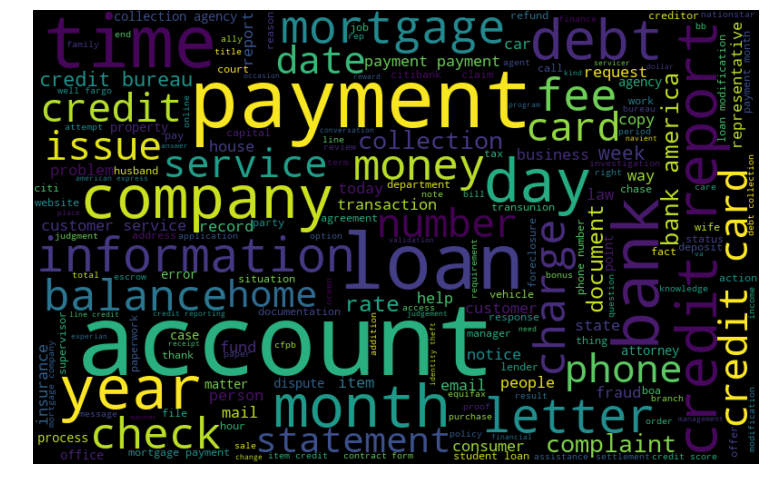

In [29]:
#Wordcloud

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(df1['cleaned'])) 
plt.figure(1,figsize=(13, 10))
fig=plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()
fig.savefig('wordcloud')

In [30]:
#Use CountVectorizer to get bigrams to visualize
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df = 0.95, min_df = 2, stop_words= 'english', max_features=10000, ngram_range=(1,3))
X = cv.fit_transform(df1['cleaned'])

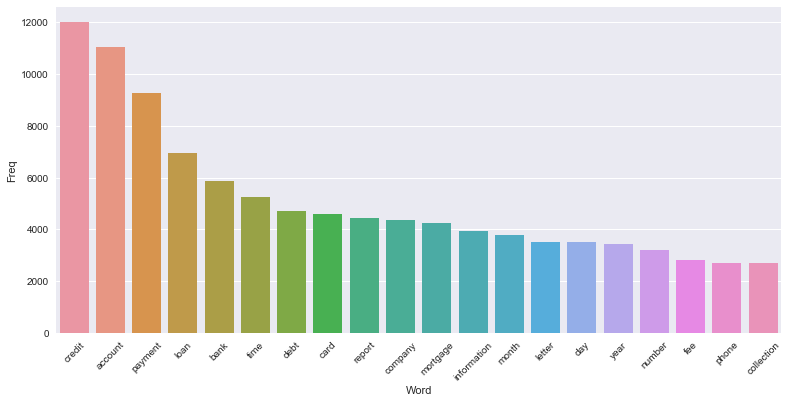

In [31]:
# Most frequently occuring words
def get_top_n_words(corpus,n=None):
    vec = CountVectorizer().fit(df1['cleaned'])
    bag_of_words=vec.transform(df1['cleaned'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word , idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Convert most freq words to datafame for visuals

top_words = get_top_n_words(df1['cleaned'], n=20)
top_df = pd.DataFrame(top_words)
top_df.columns = ['Word', 'Freq']

# barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})
g = sns.barplot(x='Word', y='Freq', data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
fig = g.get_figure()
fig.savefig("sns_output.png")

               Bi-gram  Freq
0        credit report  2620
1          credit card  1838
2          wells fargo   986
3         bank america   898
4     customer service   727
5    collection agency   704
6       credit bureaus   650
7     credit reporting   637
8         bank account   527
9         credit score   496
10   loan modification   477
11     account account   473
12      account credit   460
13        phone number   438
14       interest rate   428
15    mortgage company   409
16       report credit   407
17      credit reports   383
18  information credit   382
19     debt collection   367


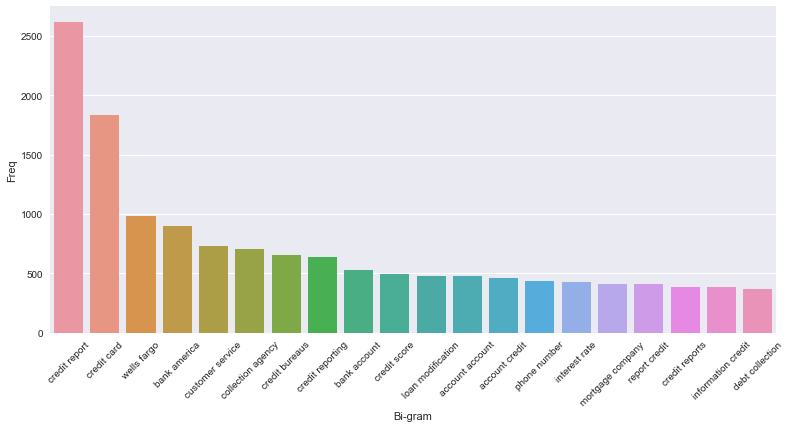

In [32]:
# Most frequently Co-occuring words
def get_top_n2_words(corpus,n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),max_features=2000).fit(df1['data_nouns'])
    bag_of_words=vec1.transform(df1['data_nouns'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word , idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Convert most freq words to datafame for visuals

top2_words = get_top_n2_words(df1['data_nouns'], n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns = ['Bi-gram', 'Freq']

# for bigram wordcloud
top100_words = get_top_n2_words(df1['data_nouns'], n=100)
top100_df = pd.DataFrame(top100_words)
top100_df.columns = ['Bi-gram', 'Freq']
print(top2_df)

# barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})
h = sns.barplot(x='Bi-gram', y='Freq', data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)
fig = h.get_figure()
fig.savefig("sns_output_bigrams.png")

In [33]:
top100_df.head()

,Bi-gram,Freq
0,credit report,2620
1,credit card,1838
2,wells fargo,986
3,bank america,898
4,customer service,727


In [34]:
top100_df['Bi_gram'] = top100_df['Bi-gram'].str.replace(' ','_')
top100_df.head()

,Bi-gram,Freq,Bi_gram
0,credit report,2620,credit_report
1,credit card,1838,credit_card
2,wells fargo,986,wells_fargo
3,bank america,898,bank_america
4,customer service,727,customer_service


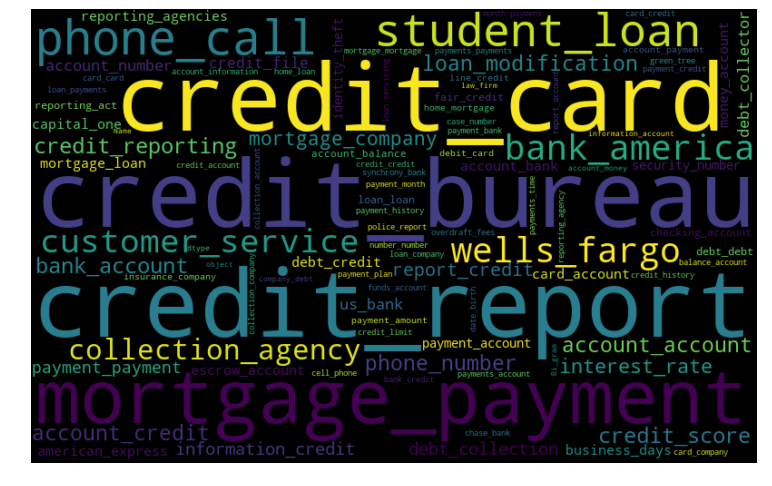

In [35]:
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(top100_df['Bi_gram'])) 
plt.figure(1,figsize=(13, 10))
fig=plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()
fig.savefig('wordcloud_bigram')

In [36]:
no_features = 10000

# Term vectorization term weighting:
- The usefulness of the document-term matrix can be improved by assigning higher weights to important terms. This helps to include or exclude terms that will enter the model.
- TF-IDF is a common way of giving weights to terms in a document.
- Term Frequency - TF is the number of times a term appears in a document.
- Inverse Document Frequency - IDF is the total number of documents that have a term. This penalises common terms that appear in almost every document.

In [37]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words= 'english', max_features=no_features, ngram_range=(1,1),
                                  analyzer='word')
tfidf = tfidf_vectorizer.fit_transform(df1['cleaned'])
# get the feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [38]:
print('Vocabulary has %d distinct terms' % len(tfidf_feature_names))

Vocabulary has 4839 distinct terms


The terms with the highest TF-IDF scores across all documents in the document-term matrix.

In [40]:
import operator
def rank_terms( tfidf, tfidf_feature_names ):
    # get the sums over each column
    sums = tfidf.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(tfidf_feature_names):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [41]:
ranking = rank_terms(tfidf, tfidf_feature_names)
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.0f)" % ( i+1, pair[0], pair[1] ) )

01. credit (527)
02. account (497)
03. payment (472)
04. loan (375)
05. bank (318)
06. debt (313)
07. card (288)
08. report (281)
09. mortgage (263)
10. time (259)
11. company (254)
12. month (228)
13. information (227)
14. letter (217)
15. number (210)
16. day (210)
17. year (205)
18. fee (203)
19. collection (199)
20. phone (186)


# NMF model fitting. 

In [42]:
no_topics = 40

In [43]:
nmf=NMF(n_components = no_topics, random_state =1, alpha=0.1, l1_ratio = 0.5, init= 'nndsvd').fit(tfidf)

In [44]:
def display_topics(model, feature_names, no_top_words):
    col1 = 'topic'
    col2 = 'top_ten_words'
    dct = {col1: [], col2: []}
    for topic_idx, topic in enumerate(model.components_):
        dct[col1].append(str(topic_idx))
        dct[col2].append(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return pd.DataFrame.from_dict(dct)

In [45]:
no_top_words = 10
topic_word = display_topics(nmf, tfidf_feature_names, no_top_words)
topic_word

,topic,top_ten_words
0,0,credit report bureau score reporting item dispute history experian transunion
1,1,payment time arrangement history day plan principal pay issue phone
2,2,fund transaction debit overdraft bank transfer account rushcard business bb
3,3,debt collector validation court creditor law recovery collection proof fdcpa
4,4,bank america boa td synchrony fraud branch action reason application
5,5,card credit purchase citi limit debit citibank store reward fraud
6,6,account checking status access activity bank saving result department issue
7,7,loan student navient school lender repayment college income education signer
8,8,number phone message person work address security time cell caller
9,9,inquiry credit right view authorization validity privacy breach birth section


In [46]:
no_top_words = 3
topic_word_3 = display_topics(nmf, tfidf_feature_names, no_top_words)
topic_word_3['Theme'] = topic_word_3.top_ten_words.str.title()
topic_word_4 = topic_word_3.loc[:,['topic', 'Theme']]
topic_word_4

,topic,Theme
0,0,Credit Report Bureau
1,1,Payment Time Arrangement
2,2,Fund Transaction Debit
3,3,Debt Collector Validation
4,4,Bank America Boa
5,5,Card Credit Purchase
6,6,Account Checking Status
7,7,Loan Student Navient
8,8,Number Phone Message
9,9,Inquiry Credit Right


In [47]:
# Merge the theme with the top_ten
topic_word = pd.merge(topic_word_4, topic_word, on ='topic')
topic_word

,topic,Theme,top_ten_words
0,0,Credit Report Bureau,credit report bureau score reporting item dispute history experian transunion
1,1,Payment Time Arrangement,payment time arrangement history day plan principal pay issue phone
2,2,Fund Transaction Debit,fund transaction debit overdraft bank transfer account rushcard business bb
3,3,Debt Collector Validation,debt collector validation court creditor law recovery collection proof fdcpa
4,4,Bank America Boa,bank america boa td synchrony fraud branch action reason application
5,5,Card Credit Purchase,card credit purchase citi limit debit citibank store reward fraud
6,6,Account Checking Status,account checking status access activity bank saving result department issue
7,7,Loan Student Navient,loan student navient school lender repayment college income education signer
8,8,Number Phone Message,number phone message person work address security time cell caller
9,9,Inquiry Credit Right,inquiry credit right view authorization validity privacy breach birth section


### Serving our model results
Append the topics to the original document for the use of our business partners.

In [48]:
nmf_W = nmf.transform(tfidf)
nmf_H = nmf.components_

In [49]:
df2 = pd.DataFrame({'topic': nmf_W.argmax(axis=1),
                   'Doc_Id': df1['Doc_Id'],
                   'consumer_complaint_narrative': df1['consumer_complaint_narrative']},
                  columns = ['topic', 'Doc_Id', 'consumer_complaint_narrative'])

In [50]:
def showdocs(df2, topics, nshow=10 ): # nshow= len(df1)
    idx = df2.topic == topics[0]
    for i in range(1, len(topics)):
        idx = idx | (df2.topic == topics[i])
    return df2[idx].groupby('topic').head(nshow).sort_values('topic')
    

In [51]:
numbers = tuple(list(range(0, no_topics)))

In [52]:
final = showdocs(df2, numbers)
final

,topic,Doc_Id,consumer_complaint_narrative
202913,0,885,"I am a father struggling to correct my credit profile. I recently paid accounts in collections, and opened new credit card accounts for the time in years. My credit was that bad. Experian and worked with me and helped out huge, from deleting items that were not supposed to be on my reports, to getting back to me in a more than timely manner on other matters. EQUIFA on the other hand, is doing the opposite. I 'm trying to remove a credit inquiry that inquired on me ( in days ), and since they are the same type and close in date, they should be deleted. Only EQUIFA REFUSED TO DO SO. The other agencies did it on the phone, right then and there with a single additional question. They knew it should n't of been there. EQUIFA, who I have called times in 2 weeks, speaking with people, say they are not removing it. This is absurd. How are these people in charge of our credit scores and reports??? I really need help with this, and little as it may sound to some, it is important..."
205553,0,1281,"I sent a letter to Transunion requesting a proper investigation regarding the public records on my credit report as I know that the public records should not have been placed on my credit report. I went to my local county clerk office to see if they could resolve the issue but they stated to me that they do not speak, email or fax to the credit bureaus and that I would have to take it up with them to resolve the issue on my report. So sent my dispute and judgments came back verified yet per my attorney who explained to me that under the FCRA which is a federal law that the credit bureaus have to conduct a reasonable investigation and make sure that the items on my credit report are accurate and verifiable. I know the judgement are not accurate and simply should not be there and how can they verify them with the county clerk or recorder when they do n't communicate in any manner to each other. This is a broken system and I need those judgments removed off my credit report as the..."
205566,0,1284,"I sent a letter to Equifax requesting a proper investigation regarding the public records on my credit report as I know that the public records should not have been placed on my credit report. I went to my local clerk office to see if they could resolve the issue but they stated to me that they do not speak, email or fax to the credit bureaus and that I would have to take it up with them to resolve the issue on my report. So sent my dispute and judgments came back verified yet per my attorney who explained to me that under the FCRA which is a federal law that the credit bureaus have to conduct a reasonable investigation and make sure that the items on my credit report are accurate and verifiable. I know the judgement are not accurate and simply should not be there and how can they verify them with the clerk or recorder when they do n't communicate in any manner to each other. This is a broken system and I need those judgments removed off my credit report as they are preventin..."
196219,0,151,"I have informed credit reporting agencies about my issue and waiting for the answer from them, Mean while I heard about CFPB and thought To file an complaint. I used in 2013 a company call freight center in to ship household items to , there was pallets, as per my knowledge weight was under lb on each pallet and paid in advance some of $2800.00 to freight center, they over charged me as per the quote so I called them and they gave me credit for an amount $85.00 same day. After 4 weeks from delivery of my house hold goods they are coming back with additional $1000.00 for additional cost which I did not get it, there fore I refuse to pay them an hidden cost and know I see they have hired collection company called , is showing on my credit report, I am going to attached a proof of documents to prove the payment was maid thru credit card. There fore I request CFPB to investigate and help me to remove this nega

In [53]:
topic_word['topic']=pd.to_numeric(topic_word['topic'])
topic_body_2 =pd.merge(topic_word, final,on='topic')
topic_body_2

,topic,Theme,top_ten_words,Doc_Id,consumer_complaint_narrative
0,0,Credit Report Bureau,credit report bureau score reporting item dispute history experian transunion,885,"I am a father struggling to correct my credit profile. I recently paid accounts in collections, and opened new credit card accounts for the time in years. My credit was that bad. Experian and worked with me and helped out huge, from deleting items that were not supposed to be on my reports, to getting back to me in a more than timely manner on other matters. EQUIFA on the other hand, is doing the opposite. I 'm trying to remove a credit inquiry that inquired on me ( in days ), and since they are the same type and close in date, they should be deleted. Only EQUIFA REFUSED TO DO SO. The other agencies did it on the phone, right then and there with a single additional question. They knew it should n't of been there. EQUIFA, who I have called times in 2 weeks, speaking with people, say they are not removing it. This is absurd. How are these people in charge of our credit scores and reports??? I really need help with this, and little as it may sound to some, it is important..."
1,0,Credit Report Bureau,credit report bureau score reporting item dispute history experian transunion,1281,"I sent a letter to Transunion requesting a proper investigation regarding the public records on my credit report as I know that the public records should not have been placed on my credit report. I went to my local county clerk office to see if they could resolve the issue but they stated to me that they do not speak, email or fax to the credit bureaus and that I would have to take it up with them to resolve the issue on my report. So sent my dispute and judgments came back verified yet per my attorney who explained to me that under the FCRA which is a federal law that the credit bureaus have to conduct a reasonable investigation and make sure that the items on my credit report are accurate and verifiable. I know the judgement are not accurate and simply should not be there and how can they verify them with the county clerk or recorder when they do n't communicate in any manner to each other. This is a broken system and I need those judgments removed off my credit report as the..."
2,0,Credit Report Bureau,credit report bureau score reporting item dispute history experian transunion,1284,"I sent a letter to Equifax requesting a proper investigation regarding the public records on my credit report as I know that the public records should not have been placed on my credit report. I went to my local clerk office to see if they could resolve the issue but they stated to me that they do not speak, email or fax to the credit bureaus and that I would have to take it up with them to resolve the issue on my report. So sent my dispute and judgments came back verified yet per my attorney who explained to me that under the FCRA which is a federal law that the credit bureaus have to conduct a reasonable investigation and make sure that the items on my credit report are accurate and verifiable. I know the judgement are not accurate and simply should not be there and how can they verify them with the clerk or recorder when they do n't communicate in any manner to each other. This is a broken system and I need those judgments removed off my credit report as they are preventin..."
3,0,Credit Report Bureau,credit report bureau score reporting item dispute history experian transunion,151,"I have informed credit reporting agencies about my issue and waiting for the answer from them, Mean while I heard about CFPB and thought To file an complaint. I used in 2013 a company call freight center in to ship household items to , there was pallets, as per my knowledge weight was under lb on each pallet and paid in advance some of $2800.00 to freight center, they over charged me as per the quote so I called them and they gave me credit for an amount $85.00 same day. After 4 weeks from delivery of my house hold go

In [54]:
topic_body_3 = pd.merge(topic_body_2, df_orig, on='Doc_Id')
topic_body_3.head()

,topic,Theme,top_ten_words,Doc_Id,consumer_complaint_narrative_x,consumer_complaint_narrative_y,product
0,0,Credit Report Bureau,credit report bureau score reporting item dispute history experian transunion,885,"I am a father struggling to correct my credit profile. I recently paid accounts in collections, and opened new credit card accounts for the time in years. My credit was that bad. Experian and worked with me and helped out huge, from deleting items that were not supposed to be on my reports, to getting back to me in a more than timely manner on other matters. EQUIFA on the other hand, is doing the opposite. I 'm trying to remove a credit inquiry that inquired on me ( in days ), and since they are the same type and close in date, they should be deleted. Only EQUIFA REFUSED TO DO SO. The other agencies did it on the phone, right then and there with a single additional question. They knew it should n't of been there. EQUIFA, who I have called times in 2 weeks, speaking with people, say they are not removing it. This is absurd. How are these people in charge of our credit scores and reports??? I really need help with this, and little as it may sound to some, it is important...","I am a XXXX father struggling to correct my credit profile. I recently paid XXXX accounts in collections, and opened XXXX new credit card accounts for the XXXX time in years. My credit was that bad. Experian and XXXX worked with me and helped out huge, from deleting items that were not supposed to be on my reports, to getting back to me in a more than timely manner on other matters. EQUIFAX on the other hand, is doing the opposite. I 'm trying to remove a credit inquiry that XXXX XXXX inquired XXXX on me ( XXXX in XXXX days ), and since they are the same type and close in date, they should be deleted. Only EQUIFAX REFUSED TO DO SO. The other XXXX agencies did it on the phone, right then and there with a single additional question. They knew it should n't of been there. EQUIFAX, who I have called XXXX times in 2 weeks, speaking with XXXX people, say they are not removing it. This is absurd. How are these people in charge of our credit scores and reports??? I really need help with th...",Credit reporting
1,0,Credit Report Bureau,credit report bureau score reporting item dispute history experian transunion,1281,"I sent a letter to Transunion requesting a proper investigation regarding the public records on my credit report as I know that the public records should not have been placed on my credit report. I went to my local county clerk office to see if they could resolve the issue but they stated to me that they do not speak, email or fax to the credit bureaus and that I would have to take it up with them to resolve the issue on my report. So sent my dispute and judgments came back verified yet per my attorney who explained to me that under the FCRA which is a federal law that the credit bureaus have to conduct a reasonable investigation and make sure that the items on my credit report are accurate and verifiable. I know the judgement are not accurate and simply should not be there and how can they verify them with the county clerk or recorder when they do n't communicate in any manner to each other. This is a broken system and I need those judgments removed off my credit report as the...","I sent a letter to Transunion requesting a proper investigation regarding the public records on my credit report as I know that the XXXX public records should not have been placed on my credit report. I went to my local county clerk office to see if they could resolve the issue but they stated to me that they do not speak, email or fax to the credit bureaus and that I would have to take it up with them to resolve the issue on my report. So sent my dispute and XXXX judgments came back verified yet per my attorney who explained to me that under the FCRA which is a federal law that the credit bureaus have to conduct a reasonable investigation and make sure that the ite

In [59]:
kmin, kmax = 4, 50

In [60]:
vectorizer = TfidfVectorizer(stop_words=my_stop_words, min_df = 20)
A = vectorizer.fit_transform(df1['consumer_complaint_narrative'])
terms = vectorizer.get_feature_names()

In [136]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF(random_state =1, init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...
Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...
Applying NMF for k=31 ...
Applying NMF for k=32 ...
Applying NMF for k=33 ...
Applying NMF for k=34 ...
Applying NMF for k=35 ...
Applying NMF for k=36 ...
Applying NMF for k=37 ...
Applying NMF for k=38 ...
Applying NMF for k=39 ...
Applying NMF for k=40 ...
Applying NMF for k=41 ...
Applying NMF for k

In [137]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [138]:
raw_documents = []
for line in df1['consumer_complaint_narrative']:
    raw_documents.append( line.strip().lower() )
print("Read %d raw text documents" % len(raw_documents))

Read 7491 raw text documents


In [139]:
raw_documents[:2]

['due to inconsistencies in the amount owed that i was told by m & t bank and the amount that was reported to the credit reporting agencies, i was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. i had a vehicle that was stolen and it was declared a total loss by insurance company. the insurance company and the gap insurancw companypaid the outstanding balance of the loan, but i was told by m & t bank that there was still a balance due on the loan. in good faith, without having received any proof as to why there was still a balance, i made a partial payment towards the remaining debt. i then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. at one point, in  2015, per my credit monitoring agency, it showed a delinquent balance of $0.00, but when i checked my credit report again on   2015, there 

In [140]:
stop_words = text.ENGLISH_STOP_WORDS

In [141]:
import gensim
docgen = TokenGenerator( raw_documents, stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [142]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 2999 terms


In [143]:
w2v_model.save("w2v-model.bin")

In [144]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [145]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [146]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

C:\Users\alber\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


K=04: Coherence=0.3189
K=05: Coherence=0.3403
K=06: Coherence=0.3493
K=07: Coherence=0.3555
K=08: Coherence=0.3543
K=09: Coherence=0.3633
K=10: Coherence=0.3590
K=11: Coherence=0.3550
K=12: Coherence=0.3557
K=13: Coherence=0.3809
K=14: Coherence=0.3835
K=15: Coherence=0.3835
K=16: Coherence=0.3877
K=17: Coherence=0.3855
K=18: Coherence=0.3939
K=19: Coherence=0.3951
K=20: Coherence=0.4037
K=21: Coherence=0.4005
K=22: Coherence=0.4038
K=23: Coherence=0.4020
K=24: Coherence=0.4121
K=25: Coherence=0.4101
K=26: Coherence=0.4079
K=27: Coherence=0.4046
K=28: Coherence=0.4049
K=29: Coherence=0.4177
K=30: Coherence=0.4158
K=31: Coherence=0.4248
K=32: Coherence=0.4210
K=33: Coherence=0.4151
K=34: Coherence=0.4092
K=35: Coherence=0.4162
K=36: Coherence=0.4133
K=37: Coherence=0.4176
K=38: Coherence=0.4135
K=39: Coherence=0.4168
K=40: Coherence=0.4139
K=41: Coherence=0.4121
K=42: Coherence=0.4247
K=43: Coherence=0.4090
K=44: Coherence=0.4138
K=45: Coherence=0.4182
K=46: Coherence=0.4092
K=47: Coher

In [147]:
import matplotlib
%mattplotlib inline
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

UsageError: Line magic function `%mattplotlib` not found.


In [ ]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [ ]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [ ]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )